In [292]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import random
import matplotlib.pyplot as plt # we only need pyplot
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
sb.set() # set the default Seaborn style for graphics

In [293]:
births = pd.read_csv('M810051_clean.csv')

births = births.rename(columns = {'Data Series':'Date'})
births.set_index('Date',inplace=True)
births = births.rename(columns=lambda x: x.strip())
#births.columns = pd.to_datetime(births.columns, format='%Y %b')
births.columns = pd.DatetimeIndex(births.columns).to_period('M')

births = births.T
births = births.rename(columns=lambda x: x.strip())
births = births.sort_index()
births.head()

Date,Total Live-Births By Ethnic Group,Malays,Chinese,Indians,Other Ethnic Groups,Total Male Live-Births By Ethnic Group,Malays,Chinese,Indians,Other Ethnic Groups,Total Female Live-Births By Ethnic Group,Malays,Chinese,Indians,Other Ethnic Groups
1960-01,4981,838,3589,467,87,2621,444,1888,240,49,2360,394,1701,227,38
1960-02,4596,836,3290,377,93,2430,434,1767,185,44,2166,402,1523,192,49
1960-03,4964,849,3639,384,92,2568,431,1883,206,48,2396,418,1756,178,44
1960-04,4904,843,3610,364,87,2516,450,1834,185,47,2388,393,1776,179,40
1960-05,5244,872,3868,392,112,2658,440,1958,196,64,2586,432,1910,196,48


PeriodIndex(['1960-01', '1960-02', '1960-03', '1960-04', '1960-05', '1960-06',
             '1960-07', '1960-08', '1960-09', '1960-10',
             ...
             '2022-03', '2022-04', '2022-05', '2022-06', '2022-07', '2022-08',
             '2022-09', '2022-10', '2022-11', '2022-12'],
            dtype='period[M]', length=756, freq='M')

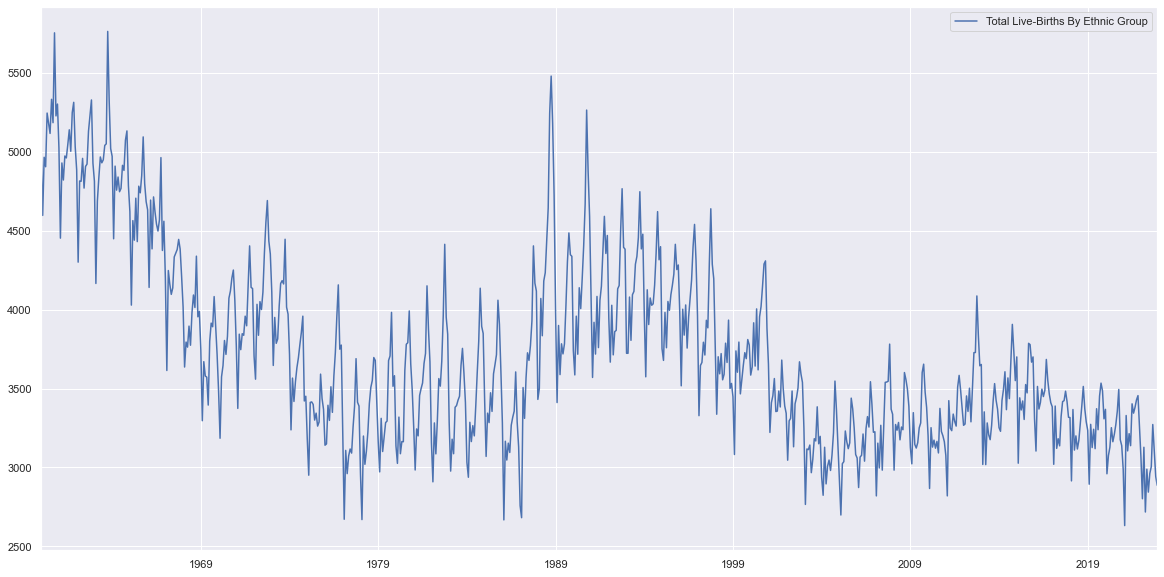

In [294]:
#remove before 1961 jan
babies = pd.DataFrame(births['Total Live-Births By Ethnic Group'])
#babies = babies[(babies.index > "1960-12")]

babies.head()
babies = babies.astype('int64')
babies.plot(figsize=(20, 10))
babies.index

In [295]:
#get values of cpi
income = pd.read_csv('17797_clean.csv')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

income.set_index('Year',inplace=True)
income.columns = income.columns.str.replace('-','')

income = income.sort_index()
income.head()
#print(income.columns)

,HDB 1 & 2 Room Flats,HDB 3Room Flats,HDB 4Room Flats,HDB 5Room & Executive Flats,Condominiums & Other Apartments,Landed Properties
Year,,,,,,
2000,876,1344,1305,1880,4035,3350
2001,803,1455,1414,2074,4524,3641
2002,807,1352,1390,2044,4173,3563
2003,773,1416,1362,1985,4228,3441
2004,811,1404,1358,1929,3961,3757


In [296]:
income1rm = pd.DataFrame(income['HDB 1 & 2 Room Flats'])
income3rm = pd.DataFrame(income['HDB 3Room Flats'])
income4rm = pd.DataFrame(income['HDB 4Room Flats'])
income5exec = pd.DataFrame(income['HDB 5Room & Executive Flats'])
incomeCondo = pd.DataFrame(income['Condominiums & Other Apartments'])
incomeLanded = pd.DataFrame(income['Landed Properties'])


income1rm.index = pd.to_datetime(income1rm.index, format='%Y')
income3rm.index = pd.to_datetime(income3rm.index, format='%Y')
income4rm.index = pd.to_datetime(income4rm.index, format='%Y')
income5exec.index = pd.to_datetime(income5exec.index, format='%Y')
incomeCondo.index = pd.to_datetime(incomeCondo.index, format='%Y')
incomeLanded.index = pd.to_datetime(incomeLanded.index, format='%Y')

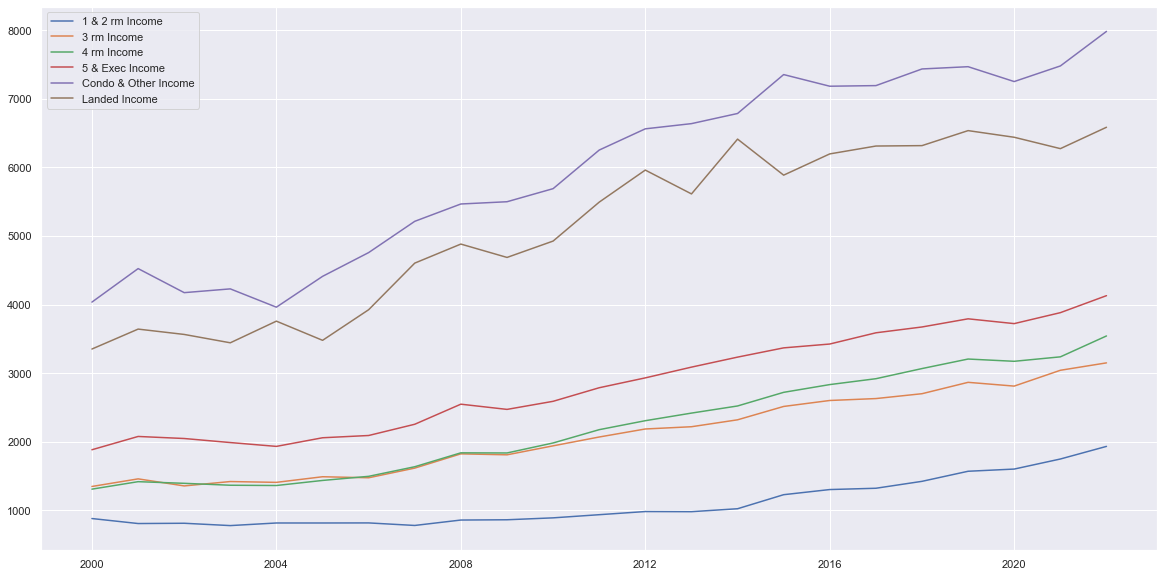

In [297]:
plt.figure(figsize=(20,10))
plt.plot(income1rm, label='1 & 2 rm Income');
plt.plot(income3rm, label='3 rm Income');
plt.plot(income4rm, label='4 rm Income');
plt.plot(income5exec, label='5 & Exec Income');
plt.plot(incomeCondo, label='Condo & Other Income');
plt.plot(incomeLanded, label='Landed Income');
plt.legend()

income datasets are too scarce. input data replication since monthly income for the year has been reported

In [298]:
income1rm_monthly = income1rm.resample('MS').pad().to_period('M')
income3rm_monthly = income3rm.resample('MS').pad().to_period('M')
income4rm_monthly = income4rm.resample('MS').pad().to_period('M')
income5exec_monthly = income5exec.resample('MS').pad().to_period('M')
incomeCondo_monthly = incomeCondo.resample('MS').pad().to_period('M')
incomeLanded_monthly = incomeLanded.resample('MS').pad().to_period('M')

Data now shows monthly income for that year, respective to household types

<AxesSubplot:>

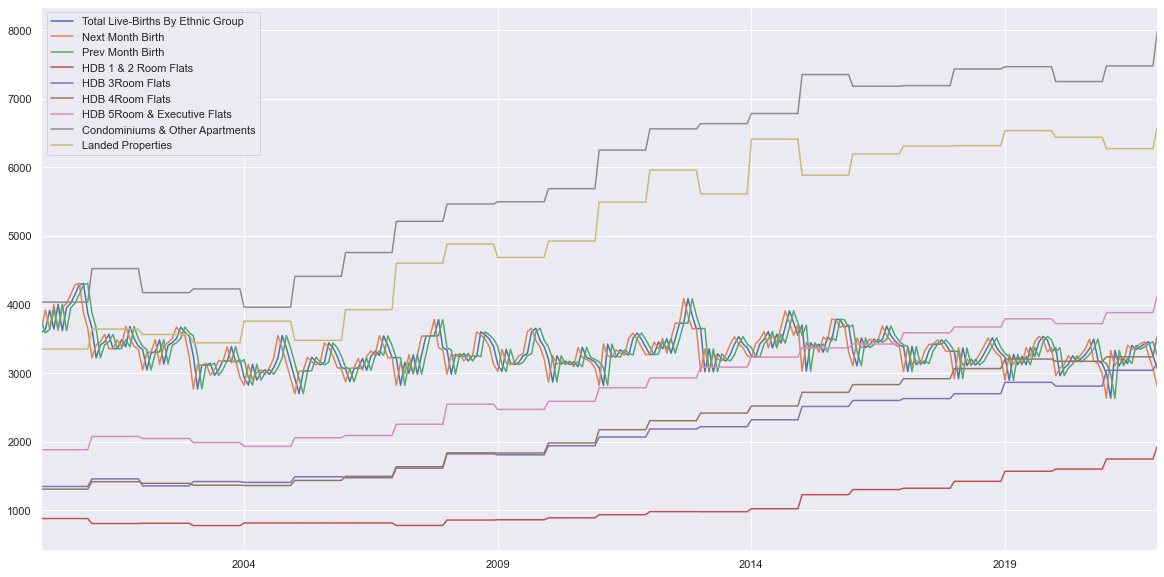

In [299]:
incomebirths = pd.DataFrame(births['Total Live-Births By Ethnic Group'])
incomebirths['Next Month Birth'] = incomebirths['Total Live-Births By Ethnic Group'].shift(-1)
incomebirths['Prev Month Birth'] = incomebirths['Total Live-Births By Ethnic Group'].shift(1)

incomebirths = incomebirths.dropna()

income1rm_monthly = incomebirths.join(income1rm_monthly['HDB 1 & 2 Room Flats'], how='inner')
income3rm_monthly = incomebirths.join(income3rm_monthly['HDB 3Room Flats'], how='inner')
income4rm_monthly = incomebirths.join(income4rm_monthly['HDB 4Room Flats'], how='inner')
income5exec_monthly = incomebirths.join(income5exec_monthly['HDB 5Room & Executive Flats'], how='inner')
incomeCondo_monthly = incomebirths.join(incomeCondo_monthly['Condominiums & Other Apartments'], how='inner')
incomeLanded_monthly = incomebirths.join(incomeLanded_monthly['Landed Properties'], how='inner')

incomeMerge = pd.concat([income1rm_monthly,income3rm_monthly,income4rm_monthly,income5exec_monthly,incomeCondo_monthly,incomeLanded_monthly], axis=1, join='inner')
incomeMerge = incomeMerge.loc[:,~incomeMerge.columns.duplicated(keep='first')]
incomeMerge.plot(figsize=(20, 10))

In [300]:
#babyCorr.info()
#babyCorr.corr()
incomeMerge.info()
incomeMerge.corr()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 265 entries, 2000-01 to 2022-01
Freq: M
Data columns (total 9 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Total Live-Births By Ethnic Group  265 non-null    int64  
 1   Next Month Birth                   265 non-null    float64
 2   Prev Month Birth                   265 non-null    float64
 3   HDB 1 & 2 Room Flats               265 non-null    int64  
 4   HDB 3Room Flats                    265 non-null    int64  
 5   HDB 4Room Flats                    265 non-null    int64  
 6   HDB 5Room & Executive Flats        265 non-null    int64  
 7   Condominiums & Other Apartments    265 non-null    int64  
 8   Landed Properties                  265 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 28.8 KB


,Total Live-Births By Ethnic Group,Next Month Birth,Prev Month Birth,HDB 1 & 2 Room Flats,HDB 3Room Flats,HDB 4Room Flats,HDB 5Room & Executive Flats,Condominiums & Other Apartments,Landed Properties
Total Live-Births By Ethnic Group,1.000000,0.676968,0.677094,-0.051284,-0.037795,-0.032970,-0.027247,0.006091,0.010223
Next Month Birth,0.676968,1.000000,0.585316,-0.066489,-0.044972,-0.041032,-0.035226,0.001926,0.014266
Prev Month Birth,0.677094,0.585316,1.000000,-0.044949,-0.036375,-0.031443,-0.026140,0.003260,0.003348
HDB 1 & 2 Room Flats,-0.051284,-0.066489,-0.044949,1.000000,0.931415,0.929620,0.917312,0.836766,0.798107
HDB 3Room Flats,-0.037795,-0.044972,-0.036375,0.931415,1.000000,0.997080,0.996056,0.974122,0.953093
HDB 4Room Flats,-0.032970,-0.041032,-0.031443,0.929620,0.997080,1.000000,0.998207,0.975101,0.956470
HDB 5Room & Executive Flats,-0.027247,-0.035226,-0.026140,0.917312,0.996056,0.998207,1.000000,0.979579,0.961585
Condominiums & Other Apartments,0.006091,0.001926,0.003260,0.836766,0.974122,0.975101,0.979579,1.000000,0.980650
Landed Properties,0.010223,0.014266,0.003348,0.798107,0.953093,0.956470,0.961585,0.980650,1.000000


In [301]:
results = []

for i in range(250):
    seed = random.randint(0, 10000)
    # Step 1: Create binary target variable
    incomeMerge['Prediction'] = (incomeMerge['Total Live-Births By Ethnic Group'] > incomeMerge['Next Month Birth']).astype(int)

    # Step 2: Combine features into single dataframe
    # Step 2.1: Predictors
    x = incomeMerge[['Total Live-Births By Ethnic Group', 'HDB 1 & 2 Room Flats','HDB 3Room Flats','HDB 4Room Flats','HDB 5Room & Executive Flats','Condominiums & Other Apartments','Landed Properties']]
    
    # Step 2.2: Response
    y = incomeMerge['Prediction']

    # Step 3: Split data into training and test sets
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)

    # Step 4: Create Random Forest Classifier object
    rf = RandomForestClassifier(n_estimators=100, max_depth=5)

    # Step 5: Fit model to training data
    rf.fit(x_train, y_train)

    # Step 6: Make predictions on test data
    y_pred = rf.predict(x_test)

    # Step 7: Evaluate performance
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    confuse = confusion_matrix(y_test, y_pred)

    results.append((seed, accuracy, precision, recall, f1, confuse))


# Sort results by F1 score in descending order
results.sort(key=lambda x: x[4], reverse=True)

In [302]:
results = results[:5]

for i in range(5):
    print('----------------------------------------------')
    print(f"Random state {results[i][0]}:")
    print(f'Accuracy  = {results[i][1]:.4f}')
    print(f'Precision = {results[i][2]:.4f}')
    print(f'Recall    = {results[i][3]:.4f}')
    print(f'F1 score  = {results[i][4]:.4f}')

print('----------------------------------------------')

----------------------------------------------
Random state 3734:
Accuracy  = 0.6981
Precision = 0.6829
Recall    = 0.9032
F1 score  = 0.7778
----------------------------------------------
Random state 412:
Accuracy  = 0.7170
Precision = 0.7027
Recall    = 0.8667
F1 score  = 0.7761
----------------------------------------------
Random state 5787:
Accuracy  = 0.7170
Precision = 0.6857
Recall    = 0.8571
F1 score  = 0.7619
----------------------------------------------
Random state 5658:
Accuracy  = 0.7170
Precision = 0.6970
Recall    = 0.8214
F1 score  = 0.7541
----------------------------------------------
Random state 3752:
Accuracy  = 0.6981
Precision = 0.7742
Recall    = 0.7273
F1 score  = 0.7500
----------------------------------------------


In [303]:
print(f'Average Accuracy:  {sum([i[1] for i in results])/5:.4f}')
print(f'Average Precision: {sum([i[2] for i in results])/5:.4f}')
print(f'Average Recall:    {sum([i[3] for i in results])/5:.4f}')
print(f'Average F1 Score:  {sum([i[4] for i in results])/5:.4f}')

Average Accuracy:  0.7094
Average Precision: 0.7085
Average Recall:    0.8351
Average F1 Score:  0.7640
